In [5]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from aotools import *



%matplotlib inline

In [6]:
telescope_diameter = .356 # meter
central_obscuration =  .114 # meter
central_obscuration_ratio = central_obscuration / telescope_diameter
#spider_width = 0.05 # meter   ##spiders not mentioned in celestron site
oversizing_factor =  147/128 #17 / 16  #NOT SURE
focallength_t = 3.910 #m
f_number = focallength_t/telescope_diameter 

focallength_l = 0.0145 #m
sh_pitch = .0005 #m
num_lenslets = 6 # lenslets along one diameter
sh_diameter = sh_pitch* num_lenslets #m
f_number_sh = focallength_l/sh_pitch
plate_scale = 0.55 #arcsec/pixel calculated in proposal doc
pixel_size = 3.45e-6 #m 
num_pupil_pixels = 1536 * oversizing_factor  # emccd is 2248x1536

wavelength = 0.55e-6  #NOT SURE
star_separation = 30 #in arcsec 

In [7]:
pupil_grid_diameter = telescope_diameter * oversizing_factor
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)

shimm_aperture_generator = make_obstructed_circular_aperture(telescope_diameter,central_obscuration_ratio)
shimm_aperture = evaluate_supersampled(shimm_aperture_generator, pupil_grid, 4)

print(shimm_aperture.shape)

(3111696,)


[0. 0. 0. ... 0. 0. 0.]


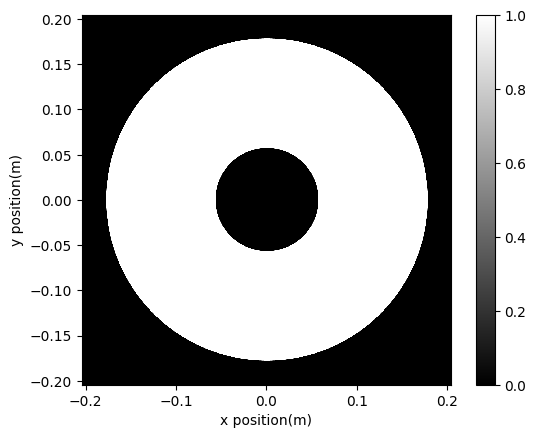

In [8]:
print(shimm_aperture)
imshow_field(shimm_aperture, cmap='gray')
plt.xlabel('x position(m)')
plt.ylabel('y position(m)')
plt.colorbar()
plt.show()

In [9]:
pos_star = np.array([0.0, 0.0])  #np.array([4.84e-4,4.84e-4])

#wf = Wavefront(shimm_aperture, wavelength)
wf = Wavefront(shimm_aperture * np.exp(2j * np.pi * np.dot(pos_star, pupil_grid.coords) / wavelength), wavelength)  
# is this to generalize wavefront based on arbitrary position of star and not just its centre ?
wf.total_power = 1

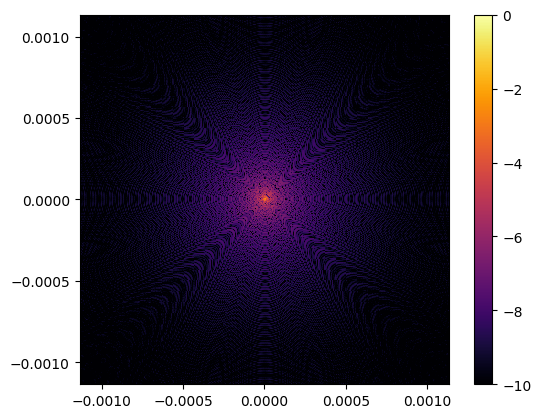

In [10]:
spatial_resolution = wavelength * f_number
focal_grid = make_focal_grid(q=5, num_airy=188, spatial_resolution=spatial_resolution)  
# required q is calculated from (spatial_resolution/pixel_size), comes out about 4.6. 
# Then num_airy is calculated by (num_lenslets*sh_pitch/spatial_reso), comes out 188 (should i use this?)

propagator = FraunhoferPropagator(pupil_grid, focal_grid)

unaberrated_PSF = propagator.forward(wf).power

imshow_field(np.log10(unaberrated_PSF / unaberrated_PSF.max()), cmap='inferno', vmin=-10)
plt.colorbar()
plt.show()

#print(spatial_resolution)

## Obtaining Shack-Hartmann spot pattern for a single star

In [11]:

magnification = sh_diameter / telescope_diameter
magnifier = Magnifier(magnification)

shwfs = SquareShackHartmannWavefrontSensorOptics(pupil_grid.scaled(magnification), f_number_sh, num_lenslets, sh_diameter)
shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index)

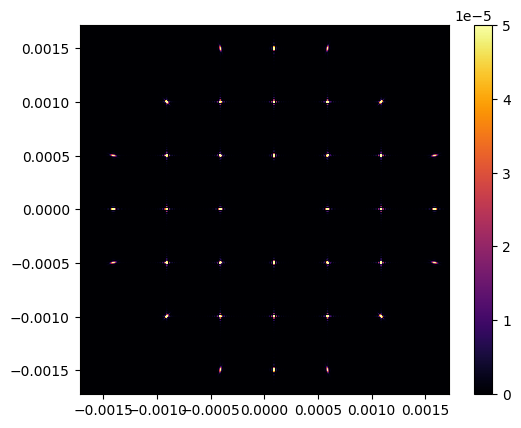

In [12]:
camera = NoiselessDetector(focal_grid)

pos_star = np.array([4.84e-5,0.0])  #np.array([4.84e-4,4.84e-4])
wf = Wavefront(shimm_aperture * np.exp(2j * np.pi * np.dot(pos_star, pupil_grid.coords) / wavelength), wavelength)
#wf = Wavefront((np.sqrt(2.512))**1 *shimm_aperture, wavelength) #to increase magnitude of star by one multiply shimm_aperture by sqrt(2.512)?
wf.total_power = 1

camera.integrate(shwfs(magnifier(wf)),1)

image_ref = camera.read_out()

imshow_field(image_ref, cmap='inferno', vmax=5.0e-5)
# imshow_field(image_ref, cmap='inferno',grid_units= pixel_size, vmax=5.0e-5)
#plt.imshow(image_ref.reshape((1764,1764)), cmap='inferno', vmax=1.0e-5)

plt.colorbar()
plt.show()



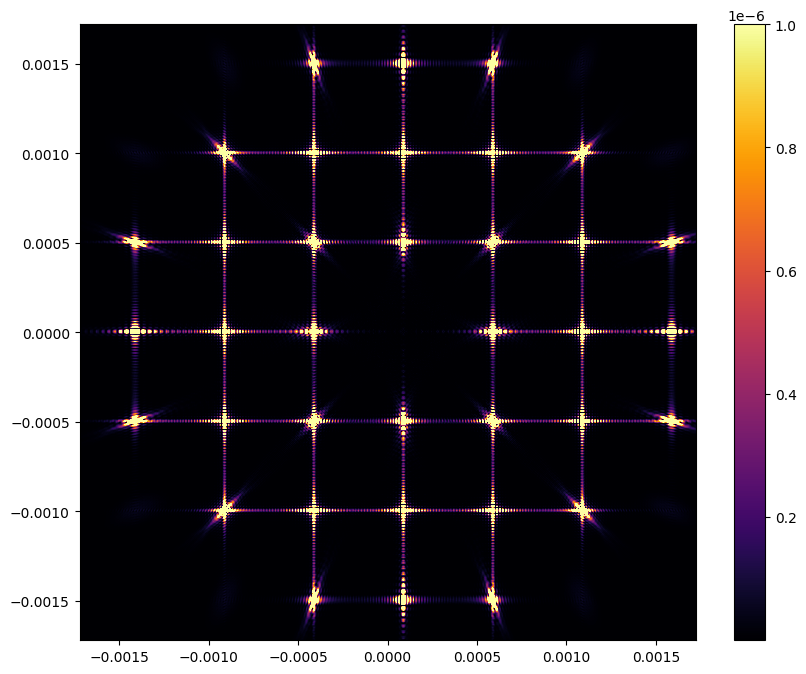

In [13]:

plt.figure(figsize=(10, 8))

imshow_field(image_ref, cmap='inferno', vmax=1.0e-6)
# plt.xlim(0.0005, 0.0015)
# plt.ylim(-0.001, 0.002)
#plt.xlim(-0.001, 0.002)
#plt.ylim(-0.001, 0.002)
plt.colorbar()
plt.show()

## Obtaining Shack-Hartmann spot pattern for a single star with seeing

In [14]:
seeing = 4.0#0.25 #in arcseconds, at Hanle. but at what wavelength?
outer_scale = 40 # meter  ##what value for Hanle?
tau0 = 0.005 # seconds  ##what value for Hanle?

fried_parameter = seeing_to_fried_parameter(seeing)
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, wavelength)
velocity = 0.314 * fried_parameter / tau0

print('r0   = {0:.3f}m'.format(fried_parameter))
print('L0   = {0:.1f}m'.format(outer_scale))
print('tau0 = {0:.1f}ms'.format(tau0 * 1000))
print('v    = {0:.1f}m/s'.format(velocity))

r0   = 0.025m
L0   = 40.0m
tau0 = 5.0ms
v    = 1.6m/s


In [15]:
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

phase_screen_phase = layer.phase_for(wavelength) # in radian
phase_screen_opd = phase_screen_phase * (wavelength / (2 * np.pi)) * 1e6



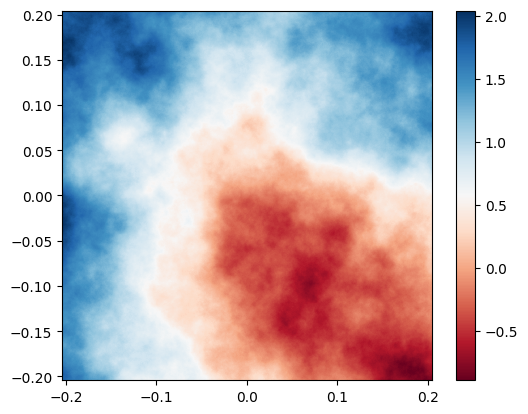

In [16]:
imshow_field(phase_screen_opd, cmap='RdBu')#,vmin=-4, vmax=4)
plt.colorbar()

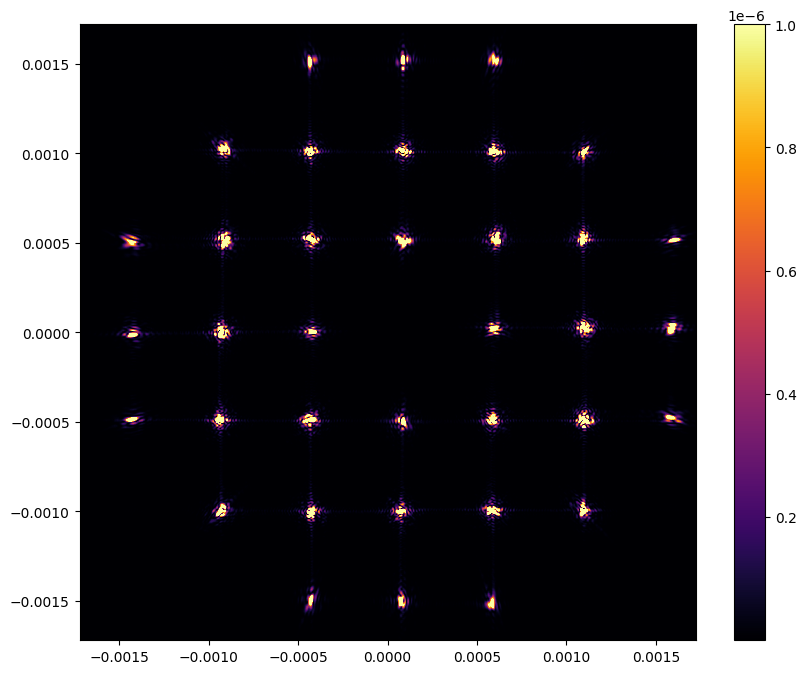

In [17]:
pos_star = np.array([4.84e-5,0.0])  #np.array([4.84e-4,4.84e-4])
wf = Wavefront(shimm_aperture * np.exp(2j * np.pi * np.dot(pos_star, pupil_grid.coords) / wavelength), wavelength)
wf_atmos= layer(wf)  # made to propagate thru atmosphere

camera.integrate(shwfs(magnifier(wf_atmos)), 1)

image_ref_atmos = camera.read_out()

plt.figure(figsize=(10, 8))

imshow_field(image_ref_atmos, cmap='inferno',vmax=1.0e-6)
# plt.xlim(0.0005, 0.0015)
# plt.ylim(-0.001, 0.002)
plt.colorbar()
plt.show()

## Obtaing SH spot pattern for 2 stars

In [18]:
camera = NoiselessDetector(focal_grid)

pos_star = np.array([np.radians(star_separation/2/3600),0.0])  #np.array([4.84e-4,4.84e-4])
wf1 = Wavefront(shimm_aperture * np.exp(2j * np.pi * np.dot(pos_star, pupil_grid.coords) / wavelength), wavelength)
wf1.total_power = 1

camera.integrate(shwfs(magnifier(wf1)),1)

image_ref1 = camera.read_out()


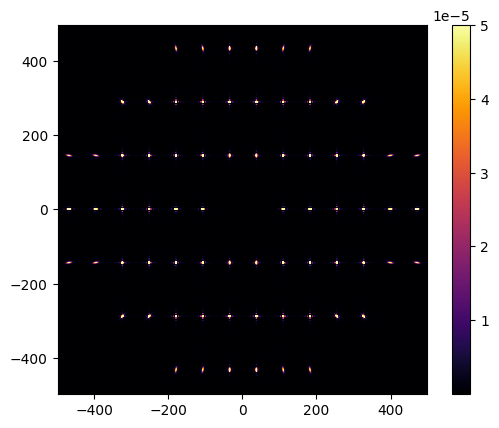

In [19]:
pos_star = np.array([np.radians(-star_separation/2/3600),0.0])  #np.array([4.84e-4,4.84e-4])
wf2 = Wavefront(shimm_aperture * np.exp(2j * np.pi * np.dot(pos_star, pupil_grid.coords) / wavelength), wavelength)
wf2.total_power = 1

camera.integrate(shwfs(magnifier(wf2)),1)

image_ref2 = camera.read_out()

image_ref= image_ref1 + image_ref2
imshow_field(image_ref, cmap='inferno',grid_units= pixel_size, vmax=5.0e-5)
#plt.imshow(image_ref.reshape((1764,1764)), cmap='inferno', vmax=1.0e-5)

plt.colorbar()
plt.show()


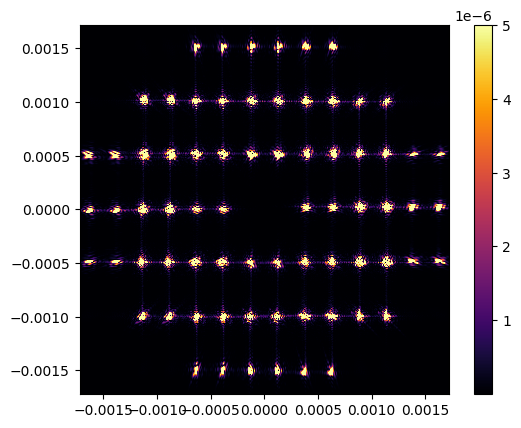

In [20]:
wf_atmos= layer(wf1)
camera.integrate(shwfs(magnifier(wf_atmos)),1)
image_ref_atmos1 = camera.read_out()

wf_atmos= layer(wf2)
camera.integrate(shwfs(magnifier(wf_atmos)),1)
image_ref_atmos2 = camera.read_out()

image_ref_atmos = image_ref_atmos1 + image_ref_atmos2
imshow_field(image_ref_atmos, cmap='inferno', vmax=0.5e-5)
plt.colorbar()
plt.show()


## Obtain centroids of the SH spots

In [21]:
image_side=int(num_pupil_pixels/7)

def make_lenslet_images(image_ref):
    lenslet_images= np.zeros((49,image_side,image_side))
    for i in range(49):
        num_rows= int((i-i%7)/7)
        for j in range(image_side):
            for k in range(image_side):
                lenslet_images[i,j,k]= image_ref[7*(num_rows*image_side+j)*image_side + (i-(num_rows*7))*image_side + k]
                
    return lenslet_images

In [22]:
centroids1= image_processing.centroiders.brightest_pixel(make_lenslet_images(image_ref1), 0.5)
print(centroids1)

#centroids2= image_processing.centroiders.brightest_pixel(make_lenslet_images(image_ref2), 0.5)
#print(centroids2)

[[195.30828953 179.76528461 185.64227168 188.57790475 191.57568794
  175.35912951  88.54719984 180.54163548 181.564191   184.43630715
  188.31717305 192.18089337 195.18526115 125.37625019 177.72824416
  180.48378732 184.3160389  188.07494514 192.61669892 196.05149243
  195.49842085 177.59543193 180.44404329 183.20156733 102.14176086
  193.35459319 196.00123295 197.58250611 177.72824416 180.48378732
  184.3160389  188.07494514 192.61669892 196.05149243 195.49842085
  180.54163547 181.564191   184.43630715 188.31717305 192.18089337
  195.18526115 125.37625019 195.30828953 179.76528461 185.64227168
  188.57790475 191.57568794 175.35912951  88.54719984]
 [150.83539851 132.76482894 115.61867926 114.85278017 115.63260019
  127.91908491 179.73561986 124.23354267 118.17523363 117.69053366
  117.6049872  117.59548712 118.42882788 110.66449835 122.01629512
  121.6542619  121.32145777 120.70922178 121.40607494 121.53957345
  122.44855704 125.5        125.5        125.5        125.5
  125.5       

In [23]:
centroids_atmos1= image_processing.centroiders.brightest_pixel(make_lenslet_images(image_ref_atmos), 0.5)
#print(centroids_atmos1)

#centroids_atmos2= image_processing.centroiders.brightest_pixel(make_lenslet_images(image_ref_atmos2), 0.5)
#print(centroids_atmos2)

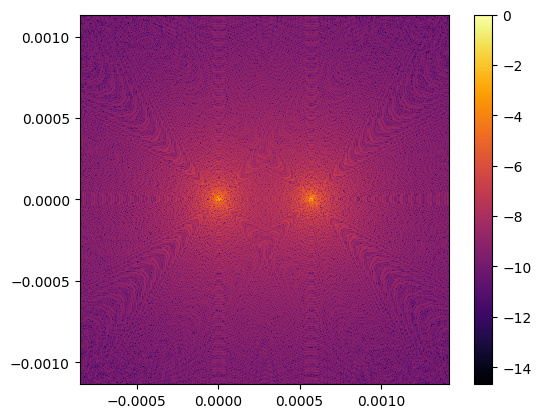

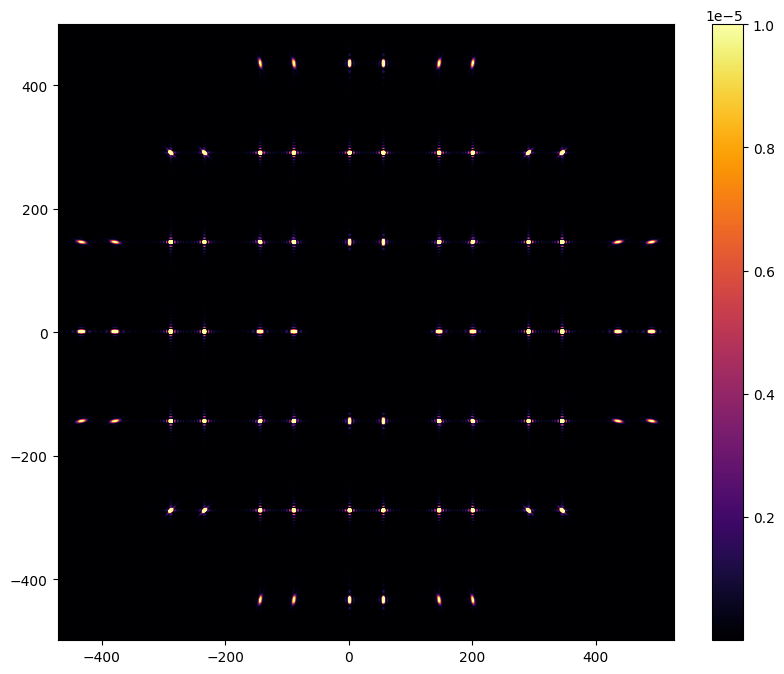

In [24]:
#my own method for shifting the star position  
    

#PSF of 2 stars
wf = Wavefront(shimm_aperture, wavelength)
wf.total_power = 1

spatial_resolution = wavelength * f_number
focal_grid = make_focal_grid(q=5, num_airy=188, spatial_resolution=spatial_resolution)

shift= focallength_t * star_separation/3600 * np.pi/180

focal_grid2= focal_grid.shifted((shift/2,0))
propagator = FraunhoferPropagator(pupil_grid, focal_grid2)
unaberrated_PSF1 = propagator.forward(wf).power

focal_grid3= focal_grid.shifted((-shift/2,0))
propagator = FraunhoferPropagator(pupil_grid, focal_grid3)
unaberrated_PSF2 = propagator.forward(wf).power

unaberrated_PSF = unaberrated_PSF1 + unaberrated_PSF2

imshow_field(np.log10(unaberrated_PSF / unaberrated_PSF.max()), cmap='inferno')#, vmin=-7)
plt.colorbar()
plt.show()

#Obtaing SH spot pattern for 2 stars

magnification = sh_diameter / telescope_diameter
magnifier = Magnifier(magnification)

shift= (star_separation/ plate_scale* pixel_size)/magnification

#print(shift)
pupil_grid2= pupil_grid.shifted((shift/2,0))
shimm_aperture_generator = make_obstructed_circular_aperture(telescope_diameter,central_obscuration_ratio)
shimm_aperture = evaluate_supersampled(shimm_aperture_generator, pupil_grid2, 4)

shwfs1 = SquareShackHartmannWavefrontSensorOptics(pupil_grid2.scaled(magnification), f_number_sh, num_lenslets, sh_diameter)
shwfse1 = ShackHartmannWavefrontSensorEstimator(shwfs1.mla_grid, shwfs1.micro_lens_array.mla_index)

camera = NoiselessDetector(focal_grid)
wf1 = Wavefront((np.sqrt(2.512))**1 *shimm_aperture, wavelength) #to increase magnitude of star by one multiply shimm_aperture by sqrt(2.512)?
camera.integrate(shwfs1(magnifier(wf1)),1)
image_ref1 = camera.read_out()
pupil_grid3= pupil_grid.shifted((-shift/2,0))
shimm_aperture_generator = make_obstructed_circular_aperture(telescope_diameter,central_obscuration_ratio)
shimm_aperture = evaluate_supersampled(shimm_aperture_generator, pupil_grid3, 4)

shwfs2 = SquareShackHartmannWavefrontSensorOptics(pupil_grid3.scaled(magnification), f_number_sh, num_lenslets, sh_diameter)
shwfse2 = ShackHartmannWavefrontSensorEstimator(shwfs2.mla_grid, shwfs2.micro_lens_array.mla_index)

camera = NoiselessDetector(focal_grid)
wf2 = Wavefront((np.sqrt(2.512))**1 *shimm_aperture, wavelength) #to increase magnitude of star by one multiply shimm_aperture by sqrt(2.512)?
camera.integrate(shwfs2(magnifier(wf2)),1)
image_ref2 = camera.read_out()

image_ref = image_ref1 + image_ref2

plt.figure(figsize=(10, 8))
imshow_field(image_ref, cmap='inferno', grid_units= pixel_size, vmax=1.0e-5)
plt.colorbar()
plt.show()
# in this image the turbulence has not been added yet

# rather than adding the focal plane intensites, what if we add the propagator.forward(wf1) + propagator.forward(wf2) and then get the power\intensities ?